# Exploring the MHW DB

In [41]:
# imports
import numpy as np
import os
from matplotlib import pyplot as plt

from datetime import date


import pandas
import sqlalchemy
import iris
import iris.quickplot as qplt

In [2]:
%matplotlib notebook

In [3]:
def match_ids(IDs, match_IDs, require_in_match=True):
    """ Match input IDs to another array of IDs (usually in a table)
    Return the rows aligned with input IDs

    Parameters
    ----------
    IDs : ndarray
    match_IDs : ndarray
    require_in_match : bool, optional
      Require that each of the input IDs occurs within the match_IDs

    Returns
    -------
    rows : ndarray
      Rows in match_IDs that match to IDs, aligned
      -1 if there is no match

    """
    rows = -1 * np.ones_like(IDs).astype(int)
    # Find which IDs are in match_IDs
    in_match = np.in1d(IDs, match_IDs)
    if require_in_match:
        if np.sum(~in_match) > 0:
            raise IOError("qcat.match_ids: One or more input IDs not in match_IDs")
    rows[~in_match] = -1
    #
    IDs_inmatch = IDs[in_match]
    # Find indices of input IDs in meta table -- first instance in meta only!
    xsorted = np.argsort(match_IDs)
    ypos = np.searchsorted(match_IDs, IDs_inmatch, sorter=xsorted)
    indices = xsorted[ypos]
    rows[in_match] = indices
    return rows


# Load up

In [139]:
mhw_file = '/home/xavier/Projects/Oceanography/MHWs/db/mhws_allsky_defaults.db'
tst_file = '/home/xavier/Projects/Oceanography/MHWs/db/test_mhws_allsky.db'

In [140]:
#engine = sqlalchemy.create_engine('sqlite:///'+mhw_file)
engine = sqlalchemy.create_engine('sqlite:///'+tst_file)

In [141]:
connection = engine.connect()
connection

# Table time

In [142]:
pd_tbl = pandas.read_sql_table('MHW_Events', con=engine, 
                               columns=['date', 'lon', 'lat', 'duration' , 
                                        'ievent', 'time_start'],
                              index_col=0)

In [143]:
pd_tbl

,date,lon,lat,duration,ievent,time_start
0,1986-01-16,0.125,-71.375,8,0,725022
1,1986-02-21,0.125,-71.375,10,1,725058
2,1986-07-08,0.125,-71.375,6,2,725195
3,1986-07-20,0.125,-71.375,8,3,725207
4,1986-09-26,0.125,-71.375,5,4,725275
...,...,...,...,...,...,...
8947,1989-01-19,0.375,-20.125,6,13,726121
8948,1989-02-26,0.375,-20.125,5,14,726159
8949,1989-05-05,0.375,-20.125,5,15,726227
8950,1989-09-26,0.375,-20.125,5,16,726371


In [144]:
sidx = []
eidx = []
counter = 0
for kk, lon,lat in zip(range(len(pd_tbl)), pd_tbl['lon'], pd_tbl['lat']):
    newc = '{:0.3f}_{:0.3f}'.format(lon, lat)
    if kk > 0 and newc != sidx[-1]:
        counter = 0
    elif kk>0:
        counter += 1
    sidx.append(newc)
    eidx.append(counter)

In [145]:
pd_tbl['lon-lat'] = sidx
#pd_tbl['eidx'] = eidx

In [146]:
pd_tbl

,date,lon,lat,duration,ievent,time_start,lon-lat
0,1986-01-16,0.125,-71.375,8,0,725022,0.125_-71.375
1,1986-02-21,0.125,-71.375,10,1,725058,0.125_-71.375
2,1986-07-08,0.125,-71.375,6,2,725195,0.125_-71.375
3,1986-07-20,0.125,-71.375,8,3,725207,0.125_-71.375
4,1986-09-26,0.125,-71.375,5,4,725275,0.125_-71.375
...,...,...,...,...,...,...,...
8947,1989-01-19,0.375,-20.125,6,13,726121,0.375_-20.125
8948,1989-02-26,0.375,-20.125,5,14,726159,0.375_-20.125
8949,1989-05-05,0.375,-20.125,5,15,726227,0.375_-20.125
8950,1989-09-26,0.375,-20.125,5,16,726371,0.375_-20.125


In [147]:
len(np.unique(pd_tbl['lon-lat']))

683

# Make a Cube

## Coords from an existing

In [149]:
noaa_path = '/home/xavier/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/'

In [150]:
file_1982 = os.path.join(noaa_path, 'sst.day.mean.1982.nc')
cubes_1982 = iris.load(file_1982)
sst_1982 = cubes_1982[0]

In [151]:
lat_coord = sst_1982.coord('latitude')
lon_coord = sst_1982.coord('longitude')

## Number of events

In [152]:
ulats = np.unique(pd_tbl['lat'])
ulons = np.unique(pd_tbl['lon'])

In [154]:
#lat_coord.points

In [155]:
i_idx = match_ids(pd_tbl['lat'], lat_coord.points, require_in_match=True)
j_idx = match_ids(pd_tbl['lon'], lon_coord.points, require_in_match=True)
#i_idx, j_idx

In [156]:
n_events  = np.zeros((lat_coord.shape[0], lon_coord.shape[0]))
for ii, jj in zip(i_idx, j_idx):
    n_events[ii,jj] += 1

In [157]:
cube = iris.cube.Cube(n_events, var_name='N_events',
                                     dim_coords_and_dims=[(lat_coord, 0),
                                                          (lon_coord, 1)])

In [158]:
cube

N Events (unknown),latitude,longitude
Shape,720,1440
Dimension coordinates,,
latitude,x,-
longitude,-,x


# Plot

## Contours

In [159]:
np.max(cube.data)

19.0

In [160]:
np.sum(cube.data > 0.) / cube.data.size

0.0006587577160493827

In [161]:
cube.data.size

1036800

<IPython.core.display.Javascript object>


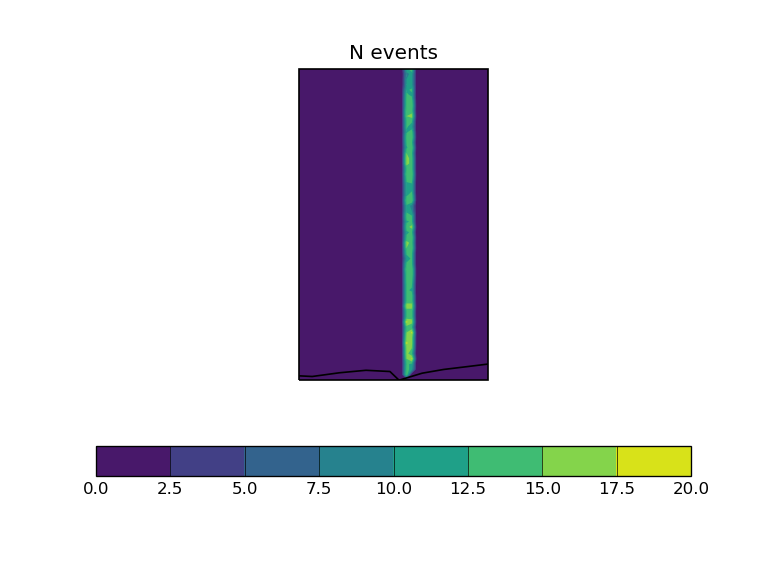

In [162]:
# Draw the contour with 25 levels.
qplt.contourf(cube)#,5, vmin=0, vmax=20)#, 5)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

## Histogram

In [30]:
hist, edges = np.histogram(n_events, 50, range=(1., 120))

<IPython.core.display.Javascript object>


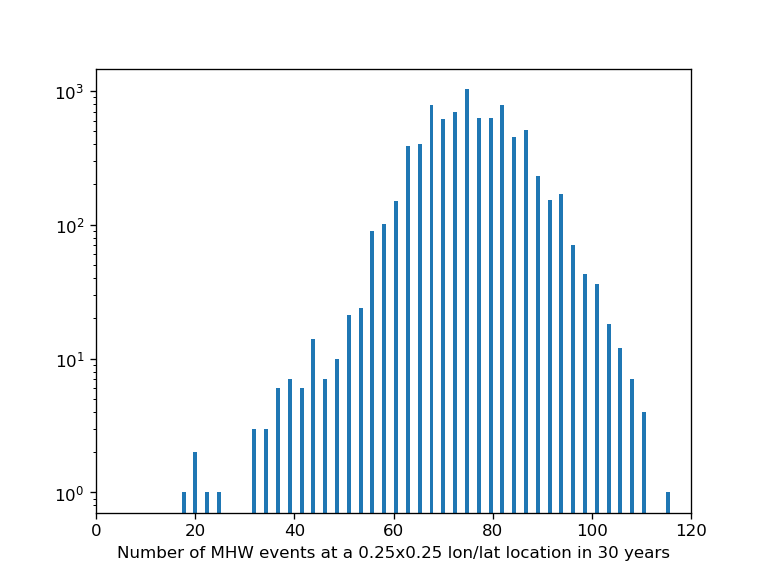

In [37]:
plt.clf()
ax = plt.gca()
ax.bar(edges[:-1], hist)
ax.set_xlim(0., 120)
ax.set_yscale('log')
#
ax.set_xlabel('Number of MHW events at a 0.25x0.25 lon/lat location in 30 years')
#
plt.show()

In [48]:
H_duration, bins_duration = np.histogram(pd_tbl['duration'], 50)#, range=(1., 120))

<IPython.core.display.Javascript object>


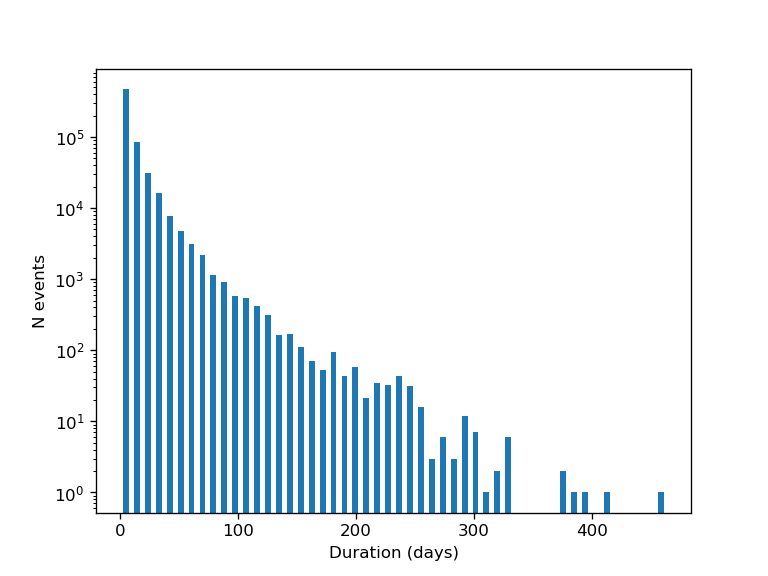

In [52]:
plt.clf()
ax = plt.gca()
ax.bar(bins_duration[:-1], H_duration, width=5)
#ax.set_xlim(0., 120)
ax.set_yscale('log')
#
ax.set_xlabel('Duration (days)')
ax.set_ylabel('N events')
#
plt.show()

# Time series

## Setup

In [43]:
dates = [date.fromordinal(tt) for tt in pd_tbl['time_start']]

In [45]:
pd_tbl['date'] = pandas.to_datetime(dates)

In [46]:
pd_tbl

,lon,lat,duration,time_start,date
0,0.125,-65.125,13,723546,1982-01-01
1,0.125,-65.125,33,723899,1982-12-20
2,0.125,-65.125,10,724671,1985-01-30
3,0.125,-65.125,9,725746,1988-01-10
4,0.125,-65.125,52,726841,1991-01-09
...,...,...,...,...,...
622918,178.625,52.375,19,735270,2014-02-06
622919,178.625,52.375,8,735761,2015-06-12
622920,178.625,52.375,11,735888,2015-10-17
622921,178.625,52.375,19,735924,2015-11-22


## Grab the 'hot spot'

In [53]:
hot_idx = np.where(n_events == np.max(n_events))
hot_idx

(array([719]), array([14]))

In [54]:
n_events.shape

(720, 1440)

In [56]:
lat_coord[719], lon_coord[14]

(DimCoord(array([89.875], dtype=float32), standard_name='latitude', units=Unit('degrees'), long_name='Latitude', var_name='lat', attributes={'actual_range': array([-89.875,  89.875], dtype=float32)}),
 DimCoord(array([3.625], dtype=float32), standard_name='longitude', units=Unit('degrees'), long_name='Longitude', var_name='lon', attributes={'actual_range': array([1.25000e-01, 3.59875e+02], dtype=float32)}))

In [58]:
most_events = pd_tbl[(pd_tbl['lon']==3.625) & (pd_tbl['lat']==89.875)]

In [62]:
most_events = most_events.set_index('date')
most_events

,lon,lat,duration,time_start
date,,,,
1982-04-06,3.625,89.875,5,723641
1982-12-12,3.625,89.875,11,723891
1983-01-01,3.625,89.875,7,723911
1983-03-02,3.625,89.875,22,723971
1983-12-02,3.625,89.875,7,724246
...,...,...,...,...
2016-07-24,3.625,89.875,17,736169
2016-09-25,3.625,89.875,7,736232
2016-11-13,3.625,89.875,11,736281


<IPython.core.display.Javascript object>


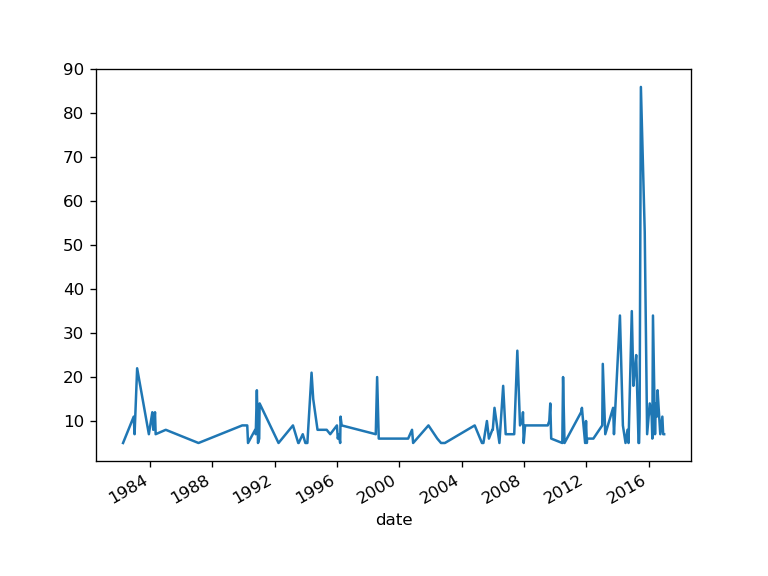

In [63]:
most_events['duration'].plot()

----

In [36]:
np.sum(n_events)

622923.0